# `Setup`

In [3]:
import pandas as pd
import numpy as np
import os

try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    !git clone https://github.com/RasKrebs/aml_itu
    %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main
    os.environ["COLAB"] = "False"


# Printing current working directory
print(os.getcwd())

Mounted at /content/drive
Cloning into 'aml_itu'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 169 (delta 3), reused 1 (delta 0), pack-reused 144
Receiving objects: 100% (169/169), 178.22 MiB | 38.54 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/aml_itu
/content/aml_itu


### `Config`

In [103]:
import yaml


In [6]:

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))

# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/imgs/train',
   'test': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `Main`

In [9]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00


In [10]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from utils.StatefarmPytorchDataset import StateFarmDataset
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, Normalize, Lambda
import torchvision.transforms.functional as TF
from torch import float32

In [11]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

def custom_transforms(image):
    # Convert image to float
    image = image.to(float32)
    # Resize image
    image = TF.resize(image, (224, 224))
    # Normalize
    image = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

    return image

# Combine custom transformations
transform_test = Compose([Lambda(custom_transforms)])

# Creating the dataset with custom transformations
train_data = StateFarmDataset(config, split='train', transform=train_transforms)
test_data = StateFarmDataset(config, split='test', transform=transform_test)

train_loader = DataLoader(train_data, batch_size=config['modeling_params']['batch_size'], shuffle=True, num_workers = 2)
test_loader = DataLoader(test_data, batch_size=config['modeling_params']['batch_size'], shuffle=False)



NEW MODEL


In [15]:
label_map = {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}

# Model Setup
model_name = 'efficientnet_b1'
model = timm.create_model(model_name, pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, 10)
)

# Device Configuration
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Load the saved model weights
model_load_path = '/content/model_weights_89acc.pth'
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))
model = model.to(torch.device('cpu'))


# Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=2e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model = model.to(device)

# Early Stopping Helper
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, verbose=True)

# Training Loop
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, label_tuple in train_loader:
        labels = [label_map[label] for label in label_tuple]
        labels = torch.tensor(labels, dtype=torch.long)  # Convert list of integers to a tensor

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, label_tuple in test_loader:
            labels = [label_map[label] for label in label_tuple]
            labels = torch.tensor(labels, dtype=torch.long)  # Convert list of integers to a tensor
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(test_loader)



In [ ]:
num_epochs = 25
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate_model(model, test_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    scheduler.step()

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients during testing
        for images, label_tuple in test_loader:
            labels = [label_map[label] for label in label_tuple]
            labels = torch.tensor(labels, dtype=torch.long)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100 * correct_predictions / total_predictions
    print(f'Accuracy on test set: {accuracy:.2f}%')

# Test the model
test_model(model, test_loader)

In [25]:
torch.save(model.state_dict(), 'model_weights_89acc.pth')


In [ ]:
test_data_img = StateFarmDataset(config, split='test') #for displaying without transformation

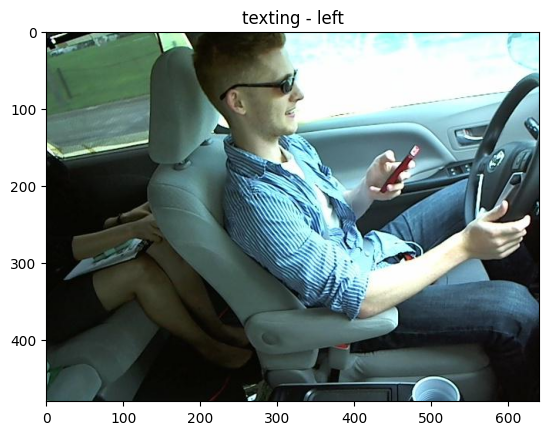

In [123]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

# Function to display an image and its predicted class
def display_prediction(model, test_dataset):
    # Ensure model is in evaluation mode
    model.eval()

    # Select a random test image
    idx = random.randint(0, len(test_dataset) - 1)
    image, _ = test_dataset[idx]

    # Preprocess the image
    input_tensor = image
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Move the input to the appropriate device
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Predict the class
    with torch.no_grad():
        output = model(input_batch)
    prediction = torch.argmax(output, dim=1).item()


    image_im, _ = test_data_img[idx] #same index but not tranformed

    image_im = transforms.ToPILImage()(image_im)

    # Display the image and its predicted class
    plt.imshow(image_im)
    plt.title(f"{config['dataset']['class_mapping']['c'+str(prediction)]}")  # Use class mapping from config
    plt.show()


display_prediction(model, test_data)



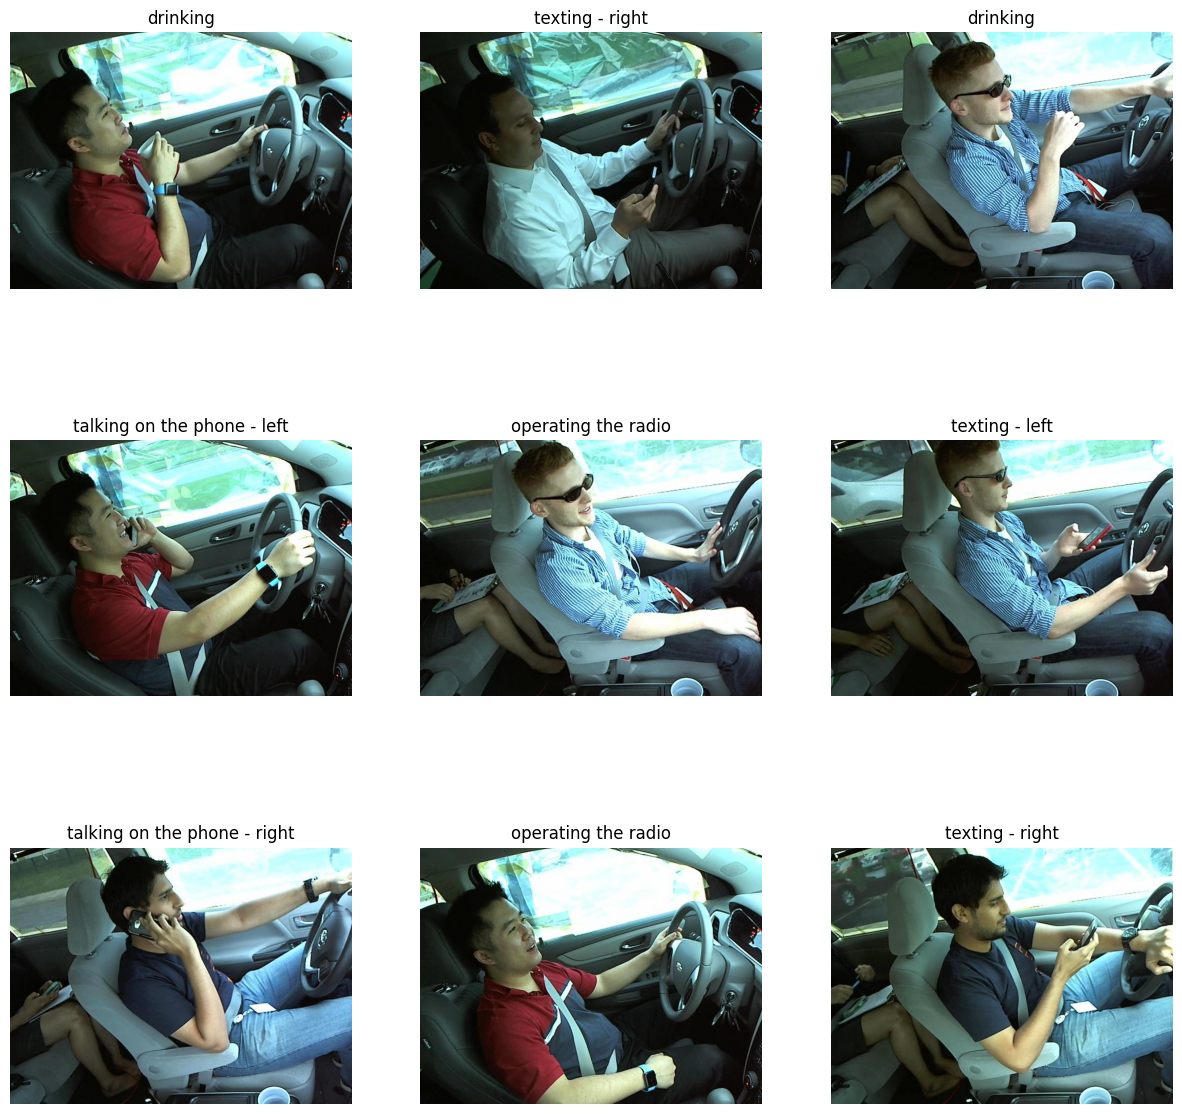

In [126]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

# Function to display an image and its predicted class
def display_prediction(model, test_dataset, idx):
    # Ensure model is in evaluation mode
    model.eval()

    # Select a test image based on index
    image, _ = test_dataset[idx]

    # Preprocess the image
    input_tensor = image
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Move the input to the appropriate device
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Predict the class
    with torch.no_grad():
        output = model(input_batch)
    prediction = torch.argmax(output, dim=1).item()

    image_im, _ = test_data_img[idx]  # Same index but not transformed
    image_im = transforms.ToPILImage()(image_im)

    return image_im, prediction

def display_nine_images(model, test_dataset):
    plt.figure(figsize=(15, 15))
    for i in range(9):
        idx = random.randint(0, len(test_dataset) - 1)
        image, prediction = display_prediction(model, test_dataset, idx)
        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.title(f"{config['dataset']['class_mapping']['c'+str(prediction)]}")  # Use class mapping from config
        plt.axis('off')
    plt.show()

# Call the function to display nine images
display_nine_images(model, test_data)
